In [1]:
import sys
from IPython.display import clear_output
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from test_dali import LSTM, Mat, LSTMState, StackedLSTM, MatOps, Layer, Graph, AdaDelta, AdaGrad, config, random as drandom, NoBackprop

In [2]:
print("was:", config.default_device)
config.default_device = 'gpu'
print("is", config.default_device)

was: gpu
is gpu


In [3]:
x = Mat(4,4)
print(x.memory_status())
x.sum()
print(x.memory_status())

{'cpu_allocated': False, 'gpu_allocated': False, 'cpu_fresh': False, 'gpu_fresh': False}
{'cpu_allocated': False, 'gpu_allocated': True, 'cpu_fresh': False, 'gpu_fresh': True}


In [4]:
x = drandom.uniform(0.5, size=(3,3), dtype = np.float32)

In [5]:
x.memory_status()

{'cpu_allocated': False,
 'cpu_fresh': False,
 'gpu_allocated': True,
 'gpu_fresh': True}

In [6]:
import time

class Throttled(object):
    decorated_to_throttled = {}
    
    def __init__(self):
        self.last_time = None
        
    def maybe_run(self, min_time_since_last_run_s, f):
        now = time.time()
        if self.last_time is None or (now - self.last_time) > min_time_since_last_run_s:
            self.last_time = now
            return f()
        else:
            return None

def throttled(min_time_between_run_s):
    def decorator(f):
        def wrapper(*args, **kwargs):
            if f not in Throttled.decorated_to_throttled:
                Throttled.decorated_to_throttled[f] = Throttled()
            t = Throttled.decorated_to_throttled[f]
            def ok_this_is_getting_ridiculous():
                return f(*args, **kwargs)
            return t.maybe_run(min_time_between_run_s, ok_this_is_getting_ridiculous)
        return wrapper
    return decorator

In [7]:
import types

def apply_recursively_on_type(x, f, target_type, list_callback=None):
    if type(x) == target_type:
        return f(x)
    elif type(x) == list or isinstance(x, types.GeneratorType):
        ret = [ apply_recursively_on_type(el, f, target_type, list_callback) for el in x]
        if list_callback and all(type(el) == target_type for el in x):
            ret = list_callback(ret)
        return ret
    elif type(x) == dict:
        res = {}
        for k,v in x.items():
            res[k] = apply_recursively_on_type(v, f, target_type, list_callback)
        return res
    else:
        return x

class VocabEncoded(int):
    pass

class Vocab(object):
    UNK = '**UNK**'
    EOS = '**EOS**'
    
    def __init__(self, add_eos=True, add_unk=True):
        self.index2word = []
        self.word2index = {}
        self.eos = None
        self.unk = None
        if add_eos:
            self.add(Vocab.UNK)
        if add_unk:
            self.add(Vocab.EOS)
            
    def __contains__(self, key):
        if type(key) == int:
            return key in range(len(self.index2word))
        elif type(key) == str:
            return key in self.word2index
        else:
            raise ValueError("expected(index or string)")

    def add(self, obj):
        def add_f(word):
            idx = self.word2index.get(word)
            if idx is None:
                idx = len(self.index2word)
                self.index2word.append(word)
                self.word2index[word] = idx
                if word is Vocab.UNK:
                    self.unk = idx
                if word is Vocab.EOS:
                    self.eos = idx
            return word
        apply_recursively_on_type(obj, add_f, str)
    
    def words(self):
        return self.word2index.keys()
    
    def __len__(self):
        return len(self.index2word)
    
    def __getitem__(self, index):
        if type(index) == int:
            return self.index2word[index]
        elif type(index) == str:
            if self.unk is not None:
                return VocabEncoded(self.word2index.get(index) or self.unk)
            else:
                return VocabEncoded(self.word2index[index])
        else:
            raise ValueError("expected(index or string)")
        
    def decode(self, obj, strip_eos=False, decode_type=int):
        def decode_f(word_idx):
            return self.index2word[word_idx]
        def decode_list_f(lst):
            if strip_eos:
                assert self.eos is not None
                return [el for el in lst if el != Vocab.EOS]
            else:
                return lst
        return apply_recursively_on_type(obj, decode_f, decode_type, list_callback=decode_list_f)
                
    def encode(self, obj, add_eos=False):
        def encode_f(word):
            if self.unk is not None:
                return VocabEncoded(self.word2index.get(word) or self.unk)
            else:
                return VocabEncoded(self.word2index[word])
        def encode_list_f(lst):
            lst = [encode_f(word) for word in lst]
            if add_eos:
                assert self.eos is not None
                lst.append(VocabEncoded(self.eos))
            return lst
        return apply_recursively_on_type(obj, lambda x:x, str, list_callback=encode_list_f)
    

In [8]:
def vocab_test1():
    vocab = Vocab()
    vocab.add([[{
        'interesting_words': ['awesome', 'cat', 'lol'],
        'daniel' : 'daniel',
        'wtf':[[[[[[[[[[[['there']]]]]]]]]]]]
    }]])
    assert(set(vocab.words()) == set(['awesome', 'there', 'daniel', '**UNK**', 'cat', '**EOS**', 'lol']))
    original = {1:{1:{1:[[[[[ 'awesome', 'but','staph', 'daniel' ]]]]]}}}
    original_with_unks = {1: {1: {1: [[[[['awesome', '**UNK**', '**UNK**', 'daniel']]]]]}}}
    encoded  = vocab.encode(original)
    decoded  = vocab.decode(encoded, decode_type=VocabEncoded)
    assert original_with_unks == decoded

    encoded  = vocab.encode(original, add_eos=True)
    decoded  = vocab.decode(encoded, strip_eos=True, decode_type=VocabEncoded)
    assert original_with_unks == decoded
vocab_test1()

In [9]:
import os


def process_files(files, mapper, reducer):
    if files == str:
        files = [files]
    for file in files:
        for element in mapper(file):
            for res in reducer(element):
                yield res

def discover_files(root_path, extension=None):
    for path, dirs, files in os.walk(root_path):
        for file in files:
            if extension is None or file.endswith(extension):
                yield os.path.join(path, file)

class Mapper(object):
    FILTER      = 1
    TRANSFORMER = 2
    def __init__(self, map_f):
        self.map_f      = map_f
        self._transformations = []
        
    def __call__(self, *args, **kwargs):
        for element in self.map_f(*args, **kwargs):
            ignore = False
            for transform_f in self._transformations:
                element = transform_f(element)
                if element is None:
                    ignore = True
                    break
            if ignore:
                continue
            yield element
    
    def add_filter(self, filter_f):
        def wrapper(element):
            if filter_f(element):
                return element
            return None
        self.add_transform(wrapper)
        return self
    
    def add_transform(self, transform_f):
        self._transformations.append(transform_f)
        return self
            
class LineExtractor(Mapper):
    def __init__(self):
        def extract_lines(file):
            with open(file, "rt") as f:
                for line in f:
                    yield line[:-1]
        super(LineExtractor, self).__init__(extract_lines)
            
    def lower(self):
        return self.add_transform(lambda x: x.lower())
        
            
    def bound_length(self, lower_bound=None, upper_bound=None):
        if lower_bound:
            self.add_filter(lambda x: lower_bound <= len(x))
        if lower_bound:
            self.add_filter(lambda x: len(x) <= upper_bound)
        return self
    
    def split_spaces(self):
        return self.add_transform(lambda x: x.split(' '))

def batched_reducer(minibatch_size,
                    minibatch_f=lambda x:x,
                    examples_until_minibatches=None,
                    sorting_key=lambda x: len(x)):
    collected = []
    examples_until_minibatches = examples_until_minibatches or minibatch_size
    def wrapper(el):
        collected.append(el)
        if len(collected) >= examples_until_minibatches:
            collected.sort(key=sorting_key)
            batch_start_idxes = list(range(0, len(collected), minibatch_size))
            random.shuffle(batch_start_idxes)
            for i in batch_start_idxes:
                if i + minibatch_size < len(collected):
                    yield minibatch_f(collected[i:(i + minibatch_size)])
    return wrapper


In [10]:
import numpy as np

class Batch(object):
    def __init__(self):
        self.timesteps = 0
        self.examples  = 0
    def inputs(timestep):
        return None
    def targets(timestep):
        return None
    
    def __repr__(self):
        return 'Batch(timesteps=%d, examples=%d)' % (self.timesteps, self.examples)

class LMBatch(object):
    START_TOKEN = '**START**'
    @staticmethod
    def given_vocab(vocab, **kwargs):
        def wrapper(sentences):
            return LMBatch(sentences, vocab, **kwargs)
        return wrapper
    
    def __init__(self, sentences, vocab, store_originals=False, add_eos=True):
        if store_originals:
            self.sentences = sentences
        sentences = [vocab.encode(s, add_eos=add_eos) for s in sentences]

        self.sentence_lengths = [len(s) for s in sentences]

        self.timesteps = max(self.sentence_lengths)
        self.examples  = len(sentences)
        # we add one index to account for start of sequence token
        self.data = np.empty((self.timesteps + 1, self.examples))
        # data is badded by EOS
        self.data.fill(vocab.eos)
        self.data[0,:].fill(vocab[LMBatch.START_TOKEN])
        for example_idx, example in enumerate(sentences):
            self.data[1:(len(example) + 1), example_idx] = example
        self.data = Mat(self.data, dtype=np.int32)
        
    def inputs(self, timestep):
        return self.data[timestep]
    
    def targets(self, timestep):
         # predictions are offset by 1 to inputs, so
        return self.data[timestep + 1]

In [11]:
def extract_bookcorpus(path, vocab, minibatch_size, sentences_until_minibatch=None, sentence_length_bounds=(2, 20)):
    sentences_until_minibatch = sentences_until_minibatch or 10000 * minibatch_size
    files   = discover_files(BOOKCORPUS, ".txt")
    mapper  = LineExtractor() \
              .lower()        \
              .split_spaces() \
              .bound_length(*sentence_length_bounds)
    reducer = batched_reducer(minibatch_size,
                              LMBatch.given_vocab(glove_vocab, store_originals=True),
                              sentences_until_minibatch)
    return process_files(files=files, mapper=mapper, reducer=reducer)

In [12]:
from collections import namedtuple

Beam = namedtuple("Beam", ["solution", "score", "state"])

def beam_search(initial_state,
                candidate_scores,
                make_choice,
                beam_width=5,
                eos_symbol = None,
                max_sequence_length=None,
                blacklist=[]):
    iterations = 0
    results = [
        Beam([], Mat(1,1), initial_state)
    ]
    
    def lazy_beam(prev_beam, candidate, new_score):
        def generate():
            return Beam(
                prev_beam.solution + [candidate],
                new_score,
                make_choice(prev_beam.state, candidate),
            )           
        return generate
    
    def lazy_identity(beam):
        def generate():
            return beam
        return generate
    
    while max_sequence_length is None or iterations < max_sequence_length:
        proposals = []
        for beam in results:
            if (eos_symbol is not None and
                    len(beam.solution) > 0 and
                    beam.solution[-1] == eos_symbol):
                proposals.append((beam.score, lazy_identity(beam)))
            else:
                scores = candidate_scores(beam.state)
                sorted_candidates = MatOps.argsort(scores)
                
                sorted_candidates = sorted_candidates[::-1]
                candidates_remaining = beam_width
                for candidate_idx in sorted_candidates:
                    if candidate_idx in blacklist:
                        continue
                    new_score = beam.score + scores.T()[candidate_idx]
                    proposals.append((new_score, lazy_beam(beam, candidate_idx, new_score)))
                    candidates_remaining -= 1
                    if candidates_remaining <= 0:
                        break
        proposals.sort(reverse=True, key=lambda x: x[0].w[0])
        results = [ eval_beam() for _, eval_beam in proposals[:beam_width]]
        
        iterations += 1
    
    return results


import math

def beam_search_test():
    MAX_LENGTH = 2
    choices = {
        #initial_choices
        "a": 0.6,
        "b": 0.4,
        #after chosing a
        "aa": 0.55,  # (total worth 0.33)
        "ab": 0.45,  # (total worth 0.18)
        #after choosing b
        "ba": 0.99,  # (total worth 0.495)
        "bb": 0.11,  # (total worth 0.044)
    };

    # Above example is designed to demonstrate greedy solution,
    # as well as better optimal solution:
    # GREEDY:    (beam_width == 1) => "aa" worth 0.33
    # OPTIMAL:   (beam_width == 2) => "ba" worth 0.495
    res_aa = Beam([0,0], Mat([math.log(0.6 * 0.55)]), "aa")
    res_ab = Beam([0,1], Mat([math.log(0.6 * 0.45)]), "ab")
    res_ba = Beam([1,0], Mat([math.log(0.4 * 0.99)]), "ba")
    res_bb = Beam([1,1], Mat([math.log(0.4 * 0.11)]), "bb")

    initial_state = "";
    def candidate_scores(state):
        ret = Mat(1,2)
        ret.w[0,0] = math.log(choices[state + "a"])
        ret.w[0,1] = math.log(choices[state + "b"])
        return ret
    def make_choice(prev_state, choice):
        return prev_state + ("a" if choice == 0 else "b")
    
    def my_beam_search(beam_width):
        return beam_search(initial_state=initial_state,
                           candidate_scores=candidate_scores,
                           make_choice=make_choice,
                           beam_width=beam_width,
                           max_sequence_length = MAX_LENGTH)
   
    def beams_equal(b1, b2):
        return (b1.solution == b2.solution and 
                np.allclose(b1.score.w, b2.score.w) and 
                b1.state == b2.state)
    
    def results_equal(a,b):
        return len(a) == len(b) and all(beams_equal(b1,b2) for b1,b2 in zip(a,b))

    #EXPECT_THROW(my_beam_search(0),std::runtime_error);
    assert results_equal(my_beam_search(1), [res_aa])
    assert results_equal(my_beam_search(2), [res_ba, res_aa])
    assert results_equal(my_beam_search(4), [res_ba, res_aa, res_ab, res_bb])
    assert results_equal(my_beam_search(10),[res_ba, res_aa, res_ab, res_bb])
    
beam_search_test()

In [13]:
class LanguageModel(object):
    def __init__(self, input_size, hiddens, vocab_size, dtype=np.float32):
        self.input_size = input_size
        self.hiddens    = hiddens
        self.vocab_size = vocab_size
        self.dtype = dtype
        
        self.encoder = drandom.uniform(-0.05, 0.05, (vocab_size, input_size), dtype=dtype)
        self.lstm    = StackedLSTM(input_size, hiddens, dtype=dtype)
        self.decoder = Layer(hiddens[-1], vocab_size, dtype=dtype)
    
    def error(self, batch):
        error = Mat(1,1)
        state = self.lstm.initial_states()
        for ts in range(batch.timesteps):
            inputs  = batch.inputs(ts)
            targets = batch.targets(ts)
            if inputs:
                encoded = self.encoder[batch.inputs(ts)]
            else:
                encoded = Mat(1, self.input_size)
            state = self.lstm.activate(encoded, state)
            if targets:
                decoded = self.decoder.activate(state[-1].hidden)
                error = error + MatOps.softmax_cross_entropy(decoded, targets).sum()
        return error
    
    def sample(self, priming, temperature=1.0, **kwargs):
        #temperature = kwargs.get("temperature", 1.0)
        with NoBackprop():
            state = self.lstm.initial_states()
            for word_idx in priming:
                encoded = self.encoder[word_idx]
                state = self.lstm.activate(encoded, state)
            def candidate_scores(state):
                return MatOps.softmax(self.decoder.activate(state[-1].hidden), temperature=temperature).log()
            def make_choice(state, candidate_idx):
                encoded = self.encoder[candidate_idx]
                return self.lstm.activate(encoded, state)

            return beam_search(state,
                               candidate_scores,
                               make_choice,
                               **kwargs)
    
    def parameters(self):
        return [self.encoder] + self.lstm.parameters() + self.decoder.parameters()

In [14]:
def show_reconstructions(model, words, temperature=1.0):
    for solution, score, _ in model.sample(glove_vocab.encode([LMBatch.START_TOKEN] + words), 
                                           eos_symbol=glove_vocab.eos,
                                           max_sequence_length=20,
                                           blacklist=[glove_vocab.unk],
                                           temperature=temperature):
        score = math.exp(score.w[0])
        priming = ' '.join(words)
        solution = ' '.join(glove_vocab.decode(solution, False))
        print('%f => [%s] %s' % (score, priming, solution))

In [15]:
GLOVE_VOCAB = '/home/sidor/projects/Dali/data/glove/vocab10k.txt'
BOOKCORPUS  = '/home/sidor/datasets/bookcorpus/'

INPUT_SIZE = 250
HIDDENS = [250, 250]
MINIBATCH = 1024
SENTENCES_UNTIL_MINIBATCH = 1000 * MINIBATCH
SENTENCE_LENGTH=(2, 10)

glove_vocab = Vocab()
glove_vocab.add(LineExtractor()(GLOVE_VOCAB))
glove_vocab.add(LMBatch.START_TOKEN)

In [16]:
model  = LanguageModel(INPUT_SIZE, HIDDENS, len(glove_vocab))

In [17]:
params = model.parameters()
s = AdaGrad(params)

In [18]:
s.step_size = 0.003

In [19]:
example_generator = extract_bookcorpus(BOOKCORPUS, glove_vocab, MINIBATCH, 
                                SENTENCES_UNTIL_MINIBATCH, sentence_length_bounds=SENTENCE_LENGTH)
error_evolution = []

In [20]:
import random

total_error, num_words = 0.0, 0

reports = Throttled()

total_error,    num_words   = 0.0, 0
batch_time, num_batches = 0.0, 0

@throttled(5)
def report(example):
    if num_batches == 0 or num_words == 0 or abs(batch_time) < 1e-6:
        return
    clear_output()
    print('Error:             ', total_error / num_words)
    print('Time per batch:    ', batch_time  / num_batches)
    print('Words per second:  ', num_words   / batch_time )
    print('Batches processed: ', num_batches)
    print('Max batch length:  ', max_timesteps)
    show_reconstructions(model, example)
    sys.stdout.flush()
    
max_timesteps = 0

batch_end_time, batch_start_time = None, None

for batch in example_generator:
    max_timesteps = max(max_timesteps, batch.timesteps)
    
    batch_start_time = time.time()
    error = model.error(batch)
    error_evolution.append(error.w[0,0] / sum(batch.sentence_lengths))

    error.grad()
    Graph.backward()
    s.step(params)
    batch_end_time = time.time()

    total_error += error.w[0, 0]
    num_words   += sum(batch.sentence_lengths)
        
    if batch_end_time is not None and batch_start_time is not None:
        batch_time += batch_end_time - batch_start_time
    num_batches    += 1
    
    example = batch.sentences[0]
    example_len = random.randint(1, len(example))
    
    report(example[:example_len])

Error:              4.35426369025
Time per batch:     0.37502988165000306
Words per second:   20583.858777872658
Batches processed:  59094
Max batch length:   11
0.077996 => [someone will take] . **EOS**
0.002083 => [someone will take] , . **EOS**
0.002046 => [someone will take] the . **EOS**
0.001554 => [someone will take] to . **EOS**
0.000077 => [someone will take] the the . **EOS**


KeyboardInterrupt: 

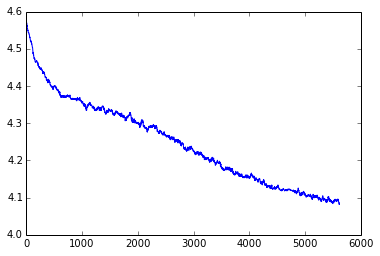

In [23]:
def median_smoothing(signal, window=10):
    res = []
    for i in range(window, len(signal)):
        actual_window = signal[i-window:i]
        res.append(np.median(actual_window))
    return res
plt.plot(median_smoothing(error_evolution, window=len(error_evolution) // 20 )[::10] )


In [22]:
len(error_evolution)

59101

In [19]:
show_reconstructions(model, "where did".split(' '), temperature=0.05)

0.967180 => [where did] . **EOS**
0.000000 => [where did] **EOS**
0.000000 => [where did] '' . **EOS**
0.000000 => [where did] i . **EOS**
0.000000 => [where did] ? . **EOS**


In [24]:
openf = False

import pickle

if openf:
    with open("/home/sidor/tmp/lm.dali", "rb") as f:
        loaded_model = pickle.load(f)
else:
    with open("/home/sidor/tmp/lm.dali", "wb") as f:
        pickle.dump(model, f)
        

In [26]:
openf = False

import pickle

if openf:
    with open("/home/sidor/tmp/lm-solver.dali", "rb") as f:
        loaded_s = pickle.load(f)
else:
    with open("/home/sidor/tmp/lm-solver.dali", "wb") as f:
        pickle.dump(s, f)
#batches_processed = 59094

In [65]:
model.__class__ = LanguageModel

In [19]:
import gc

In [19]:
w = []

def lazy_beam(c):
    def generate():
        print(c)
    return generate

for c in ["a", "b","c"]:
    w.append(lazy_beam(c))

for ww in w:
    ww()

a
b
c


In [3]:
w = []

for c in ["a", "b","c"]:
    j = c
    def lazy_beam():
        print(j)
    w.append(lazy_beam)

for ww in w:
    ww()

c
c
c
